<a href="https://colab.research.google.com/github/yeshg11/Generating-faces-using-W-GAN/blob/main/Generatingfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import torch,torchvision,os,PIL,pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import exp

In [ ]:
def show (tensor, num=25, wandbact=0, name=''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1,2,0)
## optional
  if (wandbact==1):
    wandb.log({name: wandb. Image (grid.numpy().clip(0,1))})
  plt.imshow(grid.clip(0,1))
  plt.show()

In [ ]:
n_epochs=10000
batch_size=128
Ir=1*exp(-4)
z_dim=200
d_dim=16
device="cpu" #GPU
cur_step=0
crit_cycles=5
gen_losses=[]
crit_losses=[]
show_step=35
save_step=35
wandbact=1

In [ ]:
!pip install -U wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login(key='a342169146d4428436459a22ce17da1d28e01ce9')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
experiment_name=wandb.util.generate_id()
myrun = wandb.init(
    project="wgan",
    group=experiment_name,
    settings=wandb.Settings(start_method="thread"),
    config={
        "optimizer":"sgd",
        "model":"wgan gp",
        "epoch":"1000",
        "batch_size":128,
        "timout":180
    }
)
config=wandb.config
print(experiment_name)

wandb: Currently logged in as: yeshg405. Use `wandb login --relogin` to force relogin


tcz1srlm


Generator model

In [ ]:
class Generator(nn. Module):
  def __init__(self,z_dim=64,d_dim=16):
    super(Generator,self).__init__()
    self.z_dim=z_dim
    #1x1
    self.gen=nn.Sequential(
        nn.ConvTranspose2d(z_dim, d_dim*32,4,1,0),
        nn.BatchNorm2d(d_dim*32),
        nn.ReLU(True),#4x4x512
        nn.ConvTranspose2d(d_dim*32,d_dim*16,4,2,1),
        nn.BatchNorm2d(d_dim*16),
        nn.ReLU(True),#8x8x256
        nn.ConvTranspose2d(d_dim*16,d_dim*8,4,2,1),
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(True),#16x16x128
        nn.ConvTranspose2d(d_dim*8,d_dim*4,4,2,1),
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(True),  #32x32x64
        nn.ConvTranspose2d(d_dim*4,d_dim*2,4,2,1),
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(True), #64x64x32
        nn.ConvTranspose2d(d_dim*2,3,4,2,1),
        nn.Tanh(),                      #128x128x3
    )
  def forward(self,noise):
    x=noise.view(len(noise),self.z_dim,1,1)
    return self.gen(x)
def gen_noise(num,z_dim,device=device):
  return torch.randn(num,z_dim,device=device)

*Critic model*

In [ ]:
class Critic(nn.Module):
  def __init__(self,d_dim=16):
    super(Critic,self).__init__()
    #initialize
    self.crit= nn.Sequential(#input:128x128x3
        nn.Conv2d(3,d_dim,4,2,1), #64x64x16
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0,2),

        nn.Conv2d(d_dim,d_dim*2,4,2,1),#32x32x32
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0,2),

        nn.Conv2d(d_dim*2,d_dim*4,4,2,1),#16x16x64
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0,2),

        nn.Conv2d(d_dim*4,d_dim*8,4,2,1),#8x8x128
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0,2),

        nn.Conv2d(d_dim*8,d_dim*16,4,2,1),#4x4x256
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0,2),

        nn.Conv2d(d_dim*16,1,4,1,0),#1x1x1
    )
  def forward(self,image):
    crit_pred=self.crit(image)
    return crit_pred.view(len(crit_pred),-1) #128x1


In [ ]:
#optional,initialize your weights in different ways
def init_weights(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight,0.0,0.02)
    torch.nn.init.constant_(m.bias,0)


In [ ]:
import gdown,zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_file_path = '/content/drive/My Drive/img_align_celeba.zip'
extraction_path = '/content/data/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Extraction successful.")

Extraction successful.


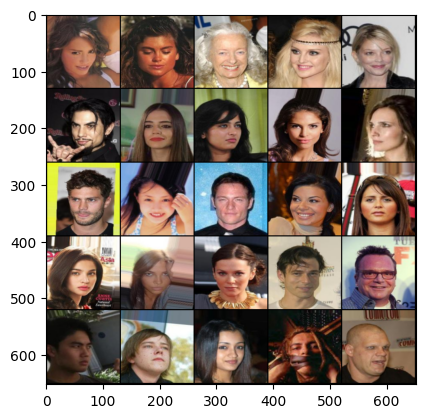

In [ ]:
### Dataset, DataLoader , declare gen , declare critic , test dataset
class Dataset(Dataset):
  def __init__(self,path,size,lim):
    self.sizes=[size,size]
    items,labels=[],[]

    for data in os.listdir(path)[:lim]:
      item= os.path.join(path,data)
      items.append(item)
      labels.append(data)
    self.items=items
    self.labels=labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self,idx):
    data=PIL.Image.open(self.items[idx]).convert('RGB') #anysize
    data=np.asarray(torchvision.transforms.Resize(self.sizes)(data)) #128x128x3
    data=np.transpose(data,(2,0,1)).astype(np.float32,copy=False) #3x128x128
    data=torch.from_numpy(data).div(255)
    return data, self.labels[idx]
  ##instantitate dataset
ds=Dataset('/content/data/img_align_celeba',128,11000)

##data loader
dataloader=DataLoader(ds,batch_size=batch_size,shuffle=True)

## Models
gen= Generator(z_dim).to(device)
critic= Critic().to(device)

## optimizers
gen_opt = torch.optim. Adam (gen.parameters(), lr=Ir, betas=(0.5,0.9))
crit_opt= torch.optim. Adam (critic.parameters(), lr=Ir, betas=(0.5,0.9))
## Initializations

if (wandbact==1):
  wandb.watch(gen, log_freq=100)
  wandb.watch(critic, log_freq=100)
  x,y=next(iter(dataloader))
  show(x)





In [ ]:
##generate gp
def get_gradient_penaulty(real,fake,critic,alpha,gama=10):
  mix_images=real*alpha+(1-alpha)*fake
  mix_scores= critic(mix_images)

  gradient = torch.autograd.grad(
      inputs=mix_images,
      outputs= mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
  )[0]
  gradient = gradient.view(len(gradient),-1) #128x49152
  gradient_norm = gradient.norm(2,dim=1)
  gp = gama *((gradient_norm-1)**2).mean()
  return gp

Loaded checkpoint


In [ ]:
## training loop
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_bs = len(real)
    real=real.to(device)

    ##critic
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()
      noise=gen_noise(cur_bs,z_dim)
      fake = gen(noise)
      critic(fake.detach())
      crit_fake_pred = critic(fake.detach())
      crit_real_pred = critic(real)
      alpha=torch.rand(len(real),1,1,1,device=device,requires_grad=True)
      gp = get_gradient_penaulty(real, fake.detach(), critic, alpha)
      crit_loss = -(-crit_fake_pred.mean() + crit_real_pred.mean()) + gp
      crit_loss.backward(retain_graph=True)
      crit_opt.step()
    crit_losses+=[mean_crit_loss]

    gen_opt.zero_grad()
    noise=gen_noise(cur_bs, z_dim)
    fake = gen(noise)
    crit_fake_pred = critic(fake)
    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()
    gen_losses+= [gen_loss.item()]

    if (wandbact==1):
      wandb.log({'Epoch': epoch, 'Step': cur_step, 'Critic loss':mean_crit_loss, 'Gen loss': gen_loss})

      gen_mean=sum(gen_losses[-show_step:]) / show_step
      crit_mean = sum(crit_losses[-show_step:]) / show_step
      print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label="Generator Loss"
      )

      plt.plot(
          range(1, len(crit_losses) + 1),
          torch.Tensor(crit_losses),
          label="Critic Loss"
      )

      plt.ylim(-150,150)
      plt.legend()
      plt.show()

    cur_step+=1



In [ ]:
import torch

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU found.")

No GPU found.
